In [1]:
import pandas as pd
import numpy as np
import string
import pickle
import json
import re

import matplotlib.pyplot as plt
import seaborn as sns
import nltk.data

from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from rouge import Rouge
import torch
from transformers import BertTokenizer

In [2]:
TOKENIZER = nltk.data.load('tokenizers/punkt/russian.pickle')
PATH_TO_DATA = './headline_gen_baselines/data/ria.json'
SEED = 1234

## 1. Читаем данные:

In [3]:
def read_data(path_to_data):
    with open(path_to_data) as f:
        data = [json.loads(line) for line in f]
        data = pd.DataFrame(data)
        return data

In [4]:
data = read_data(PATH_TO_DATA)

display(data.head(2))
display(data.shape)

text  \
0  <p><strong></strong></p>\n<p><strong>москва, 3...   
1  <p><strong></strong></p>\n<p><strong>киев, 31 ...   

                                               title  
0  большинство детей, которых пытались увезти в с...  
1  луценко будет работать в команде тимошенко, ес...

(1003869, 2)

## 2. Чистим тексты:

1. Убрать html разметку
2. Убрать все символы короме русских и английских букв, цифр и пунктуации
3. Убрать текста в которых нет русского языка

In [213]:
HTML_REGEX = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
NOT_TARGET_SYMBOLS_REGEX = re.compile(r'[^a-zA-Z0-9а-яА-Я \.,;:!\?\-"\')(]+')
RUSSIAN_LETTERS_REGEX = re.compile(r'[а-яА-Я]+')
ADD_SPACE_REGEX = re.compile(r'(?<=[.,?!:;])(?=[^\s])')
ADD_SPACE_BETWEEN_DIGITS_AND_LETTERS = re.compile('(\d+(\.\d+)?)')
REMOVE_SPACE_BETWEEN_PUNCTUATION = re.compile('(?<=[:.,!?()]) (?=[:.,!?()])')

def clean_data(raw_text):
    
    def clean_html(raw_text):
        cleaned_text = re.sub(HTML_REGEX, '', raw_text)
        return cleaned_text
    
    def clean_not_target_symbols(raw_text):
        cleaned_text = re.sub(NOT_TARGET_SYMBOLS_REGEX, '', raw_text)
        return cleaned_text
    
    def clean_double_whitespaces(raw_text):
        cleaned_text = ' '.join(raw_text.split())
        return cleaned_text
    
    def check_russian_letters(raw_text):
        if re.search(RUSSIAN_LETTERS_REGEX, raw_text):
            return True
        else:
            return False
        
    def add_space_after_some_punctuation(raw_text):
        cleaned_text = re.sub(ADD_SPACE_REGEX, r' ', raw_text)
        return cleaned_text
    
    def add_space_between_digits_and_letters(raw_text):
        cleaned_text = re.sub(ADD_SPACE_BETWEEN_DIGITS_AND_LETTERS, r' \1 ', raw_text)
        return cleaned_text
    
    def remove_space_between_punctuation(raw_text):
        cleaned_text = re.sub(REMOVE_SPACE_BETWEEN_PUNCTUATION, '', raw_text)
        return cleaned_text
        
    if check_russian_letters(raw_text):
        cleaned_text = clean_html(raw_text)
        cleaned_text = clean_not_target_symbols(cleaned_text)
        cleaned_text = add_space_after_some_punctuation(cleaned_text)
        cleaned_text = add_space_between_digits_and_letters(cleaned_text)
        cleaned_text = clean_double_whitespaces(cleaned_text)
        cleaned_text = remove_space_between_punctuation(cleaned_text)
        return cleaned_text
    else:
        return ''

In [6]:
data = data.transform([clean_data])
data.columns = ['text', 'title']

display(data.head(2))
display(data.shape)

text  \
0  москва, 31 янв - риа новости. большая часть из...   
1  киев, 31 янв - риа новости, марина шмаюн. прем...   

                                               title  
0  большинство детей, которых пытались увезти в с...  
1  луценко будет работать в команде тимошенко, ес...

(1003869, 2)

## 3. Добавляем фичи:

1. Длина текста
2. Длина заголовка
3. Кол-во слов в тексте
4. Кол-во слов в заголовке
5. Кол-во предложений в тексте
6. Кол-во предложений в заголовке

In [7]:
def add_features(data):
    data['text_len'] = data.text.transform(len)
    data['title_len'] = data.title.transform(len)
    
    data['text_n_words'] = data.text.str.split(' ', expand=False).agg([len])
    data['title_n_words'] = data.title.str.split(' ', expand=False).agg([len])
    
    data['text_n_sentences'] = data.text.transform([lambda x: len(TOKENIZER.tokenize(x))])
    data['title_n_sentences'] = data.title.transform([lambda x: len(TOKENIZER.tokenize(x))])
    
    return data

In [8]:
data = add_features(data)

display(data.head(2))
display(data.shape)

text  \
0  москва, 31 янв - риа новости. большая часть из...   
1  киев, 31 янв - риа новости, марина шмаюн. прем...   

                                               title  text_len  title_len  \
0  большинство детей, которых пытались увезти в с...      2542         68   
1  луценко будет работать в команде тимошенко, ес...      1187         70   

   text_n_words  title_n_words  text_n_sentences  title_n_sentences  
0           348             11                12                  1  
1           175             11                 9                  1

(1003869, 8)

## 4. Посмотрим на распределение:

In [9]:
def set_font_size(ax):
    items = [ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()
    
    for item in items:
        item.set_fontsize(20)
        
    return ax

### По тексту:

<AxesSubplot:xlabel='text_n_sentences', ylabel='Count'>

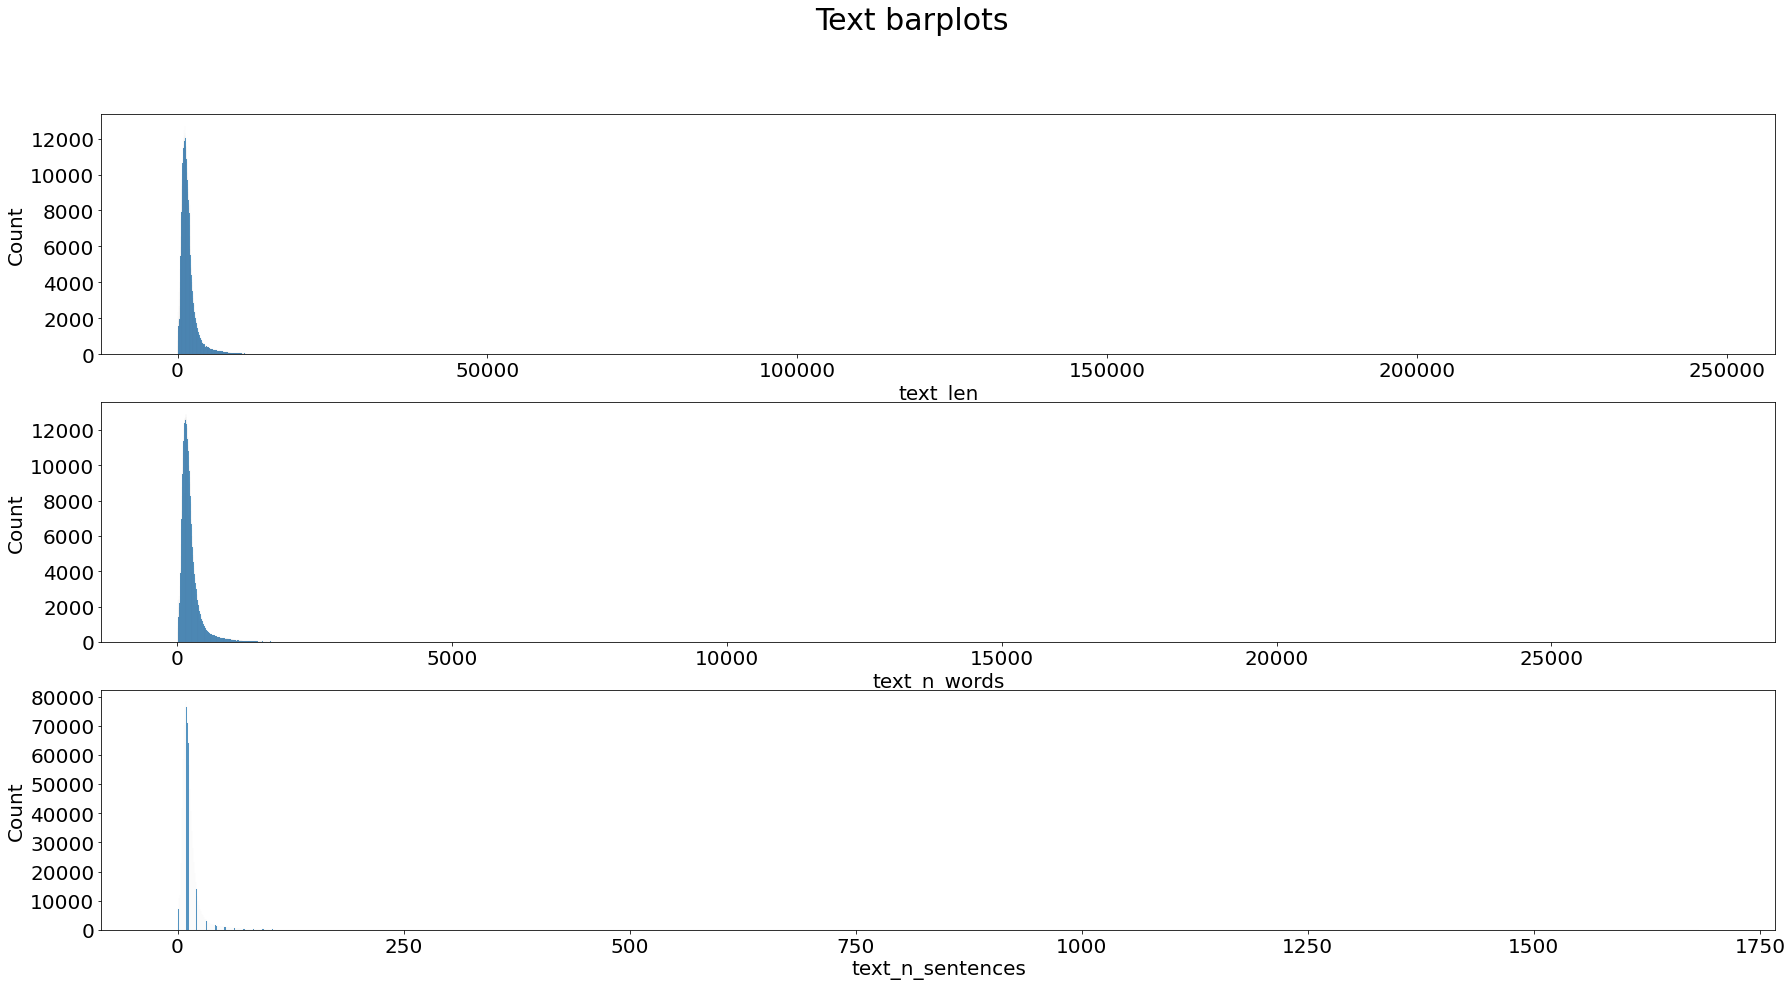

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(30, 15))
fig.suptitle('Text barplots', fontsize=30)

axes = [set_font_size(ax) for ax in axes]

sns.histplot(data.text_len, ax=axes[0])
sns.histplot(data.text_n_words, ax=axes[1])
sns.histplot(data.text_n_sentences, ax=axes[2])

### По заголовку:

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(30, 15))
fig.suptitle('Title barplots', fontsize=30)

axes = [set_font_size(ax) for ax in axes]

sns.histplot(data.title_len, ax=axes[0])
sns.histplot(data.title_n_words, ax=axes[1])
sns.histplot(data.title_n_sentences, ax=axes[2])

<AxesSubplot:xlabel='title_n_sentences', ylabel='Count'>

## 5. Чистим данные:

1. Убираем выбросы по длине текста
2. Убираем выбросы по длине заголовка
3. Убираем текста в которых всего 1 слово
4. Убираем текст, если он совпадает с заголовком
5. Убираем текст, если длина текста меньше длины заголовка

In [12]:
data = data[
    (data.text_len <= 10000) &
    (data.title_n_sentences != 0) &
    (data.text_n_words > 1) &
    (data.text != data.title) &
    (data.text_len > data.title_len)
]

display(data.head(2))
display(data.shape)

text  \
0  москва, 31 янв - риа новости. большая часть из...   
1  киев, 31 янв - риа новости, марина шмаюн. прем...   

                                               title  text_len  title_len  \
0  большинство детей, которых пытались увезти в с...      2542         68   
1  луценко будет работать в команде тимошенко, ес...      1187         70   

   text_n_words  title_n_words  text_n_sentences  title_n_sentences  
0           348             11                12                  1  
1           175             11                 9                  1

(991886, 8)

### Посмотрим, как выглядят данные, длина текста которых близка к нулю:

In [13]:
data.sort_values(by='text_len').head(50)

text                title  text_len  title_len  \
46495                мир вам.                 олег         8          4   
50396              мы с вами!              алексей        10          7   
48275            скорблю ....            александр        12          9   
49125           очень жаль...              татьяна        13          7   
50510          храни вас бог!                павел        14          5   
46271          нам очень жаль             светлана        14          8   
50495          скорбим вместе            александр        14          9   
44258         простите нас...            виктор в.        15          9   
48032         скорблю с вами.              дмитрий        15          7   
49870         скорбим вместе.                 гуля        15          4   
48320        мы тоже скорбим.               сергей        16          6   
47803       сострадаю с вами.               виктор        17          6   
50045       скорблю.. молюсь.             вячеслав        17          8   
47765       крепитесь, други!                  птр        17          3   
49909       вместе скорбим!!!              василий        17          7   
48091      скорбим. держитесь                вадим        18          5   
45833      скорбим и молимся.              николай        18          7   
51433      мы всегда рядом!!!            александр        18          9   
50365      крепитесь славяне!                 юрий        18          4   
51144      соболезную славяне                вадим        18          5   
43248      братья, мы с вами!            александр        18          9   
51161      держитесь, братья.                 иван        18          4   
50339      крепитесь славяне!                 юрий        18          4   
47166     скорбим! держитесь.                мария        19          5   
73396     славяне, крепитесь!              василий        19          7   
48792     cпоcuбо вaм всем!!!                 юзek        19          4   
48791     царство небесное...                 юрий        19          4   
612896    барби-кафе втайпее.   кафе в стиле барби        19         18   
50907     мы, скорбим с вами!                ирина        19          5   
51141     искренне соболезную             владимир        19          8   
45083     мы с вами друзья!!!                игорь        19          5   
50742    искренне соболезную.               сергей        20          6   
831744   тест лида версия два            тест лида        20          9   
44685    искренне соболезную.                  яна        20          3   
49920    держитесь, родные...  татьяна афанасьевна        20         19   
51101    скорбим и молимся...               марина        20          6   
49245   поляки, питер с вами!                ирина        21          5   
49600   искренне соболезнуем.             светлана        21          8   
50466   скорбим вместе с вами              алексей        21          7   
51051   вс будет нормально...                 влад        21          4   
50324   сочувствуем! скорбим!                павел        21          5   
47771   мои соболезнования...              евгений        21          7   
50285   сочувствуем! скорбим!                павел        21          5   
48160   держитесь. мы с вами.                роман        21          5   
48218   искренне соболезнуем.   светлана, портниха        21         18   
50698   нет предела скорби...                 нина        21          4   
51142   держитесь. мы с вами.             светлана        21          8   
50234   я вас люблю держитесь              рафаэль        21          7   
48381   думаю и плачу за вас.            александр        21          9   
47315   поляки, питер с вами!                ирина        21          5   

        text_n_words  title_n_words  text_n_sentences  title_n_sentences  
46495              2              1                 1                  1  
50396              3              1              

Видим, что в данные попали комментарии людей, где в качестве заголовка выступает ФИО автора.
Попробуем выделить такие данные.

Подгрузим небольшой словарь имен и проставим метку является ли заголовок ФИО, а так же содержится ли фио в самом тексте.

In [14]:
with open('names.list', 'rb') as f:
    NAMES = pickle.load(f)

In [15]:
def check_fio(x):
    splitted = x.strip().split()
    if len(splitted) > 3:
        return False
    elif len(splitted) == 1:
        if splitted[0] in NAMES:
            return True
        else:
            return False
    elif len(splitted) == 2:
        if splitted[0] in NAMES and splitted[1] in NAMES:
            return True
        else:
            return False
    elif len(splitted) == 3:
        if splitted[0] in NAMES and splitted[1] in NAMES and splitted[2] in NAMES:
            return True
        else:
            return False
    else:
        return False

In [16]:
data['title_is_fio'] = data.title.apply(lambda x: check_fio(x))

In [17]:
def check_fio_in_text(row):
    splitted_fio = row.title.strip().split()
    if any([el in row.text for el in splitted_fio]):
        return True
    else:
        return False

data['title_is_part_of_text'] = data.apply(lambda row: check_fio_in_text(row), axis=1)

Отфильтруем заголовки которые являются ФИО, при этом само ФИО не содержится в тексте (исключаем заголовки, в которых говорится о каких-то известных людях). Посмотрим как выглядят такие данные:

In [18]:
data[
    ((data.title_is_part_of_text == False) & (data.title_is_fio == True)) |
    ((data.title_is_part_of_text == True) & (data.title_is_fio == True) & (data.title_n_words == 1))
].head(50)

text              title  \
42137  весь таджикский народ в этой трагедии скорбит ...              шараф   
42155  уважаемый польский народ! в этот ужасный траги...              игорь   
42165           скорбим и молимся. держитесь, дорогие...               анна   
42177  сострадаем вместе с польскими людьми о тех, кт...              ольга   
42180  произошла страшная трагедия... погибло много л...           владимир   
42298  когда случается большое горе, все мелкое уходи...               майя   
42302  прошло 16 дней, а я по-прежнему в шоке... при ...             лариса   
42306  szkoda. bardzo szkoda.(слишком плохо. очень жа...              игорь   
42315  погибли люди. скорблю, сочуствую всем полякам....           вячеслав   
42368              у горя нет границ. мы скорбим с вами.             марина   
42404              у горя нет границ. мы скорбим с вами.             марина   
42420  тяжелая, дикая, невосполнимая утрата... обопри...             галина   
42436  выражаю соболезнование родным и близким, всему...            гульнар   
42523  братья и сестры! я в тот злополучный день ехал...              роман   
42525  в 90 -е годы работала в польше, узнала поляков...              софья   
42528  мы скорбим вместе с вами... мы должны быть сил...            наталья   
42529  соболезнования родным и близким всех погибших....             сергей   
42535  уважаемые граждане польши! трагедии в катыни -...            людмила   
42537  соболезную родным и близким погибших, всему по...            дмитрий   
42539  всм рдним близьким терпння мужност пережити це...            татьяна   
42545  соболезную и преклоняю голову перед погибшими....               илья   
42546  мы соскучились за польшей и за поляками. мое п...  сергей калашников   
42548  расцениваю случившееся как личную трагедию. мо...               анна   
42550  скорбим вместе с вами.. трагедия потрясла всю ...             любовь   
42554  очень болит душа от одних мыслей об этой траге...              ольга   
42555  покойтесь с миром! поклон и соболезнования род...               юлия   
42559  очень сложно найти слова утешения для людей, п...            наталия   
42565  ужасно то, что случилось. в такие страшные мин...             рустем   
42574  никогда не забудем эту боль, мы всегда с вами!...            наталья   
42579  терять близких, родных и дорогих людей всегда ...              ирина   
42581  чтобы у вас были силы справиться с горем, мы, ...            алексей   
42585  уфа вместе с вами... мамы, папы, дети погибших...            альфира   
42610  искренне соболезнуем вам, дорогие наши братья....           светлана   
42614  мой отец и бабушка - поляки. они умерли более ...            людмила   
42616  самые искренние соболезнования всем полякам, м...              ирина   
42620  самые искренние соболезнования всем жителям по...               илья   
42624  всей душой болею за вас, сопереживаю и беспоко...               нина   
42645  горя чужого не бывает, горе брата это тво горе...            евгений   
42646  искренне соболезную гражданам польши, близким ...              ирина   
42648  уважаемые поляки. искренне соболезную вам. я п...              елена   
42654  очень надеюсь, что трагедия, постигшая польшу,...           анатолий   
42656  невосполнимая утрата, польша, мы всегда будем ...          маргарита   
42661  мне уже довольно много лет, и всякое было на м...             галина   
42662          искренне соболезнуем польскому народу....      жанна авдеева   
42663  искренние, глубочайшие соболезнования тебе, по...            алексей   
42664  вашу утрату разделяет народ россии. скорбим и ...      ольга вилкова   
42666                гибель людей - это всегда трагедия.         константин   
42668  искренние соболезнования всему польскому народ...     наталья ревина   
42845  это стало шоком не только для польши. но и для...             михаил   
42848  сколько сирот осталось! дети и матери осиротел...               алла   

       text_len  title

## В результате чистки получим такие данные:

In [19]:
data = data[
    ~((data.title_is_part_of_text == False) & (data.title_is_fio == True)) &
    ~((data.title_is_part_of_text == True) & (data.title_is_fio == True) & (data.title_n_words == 1))
].sort_values(by=['text_len', 'title_len'])

<AxesSubplot:xlabel='text_n_sentences', ylabel='Count'>

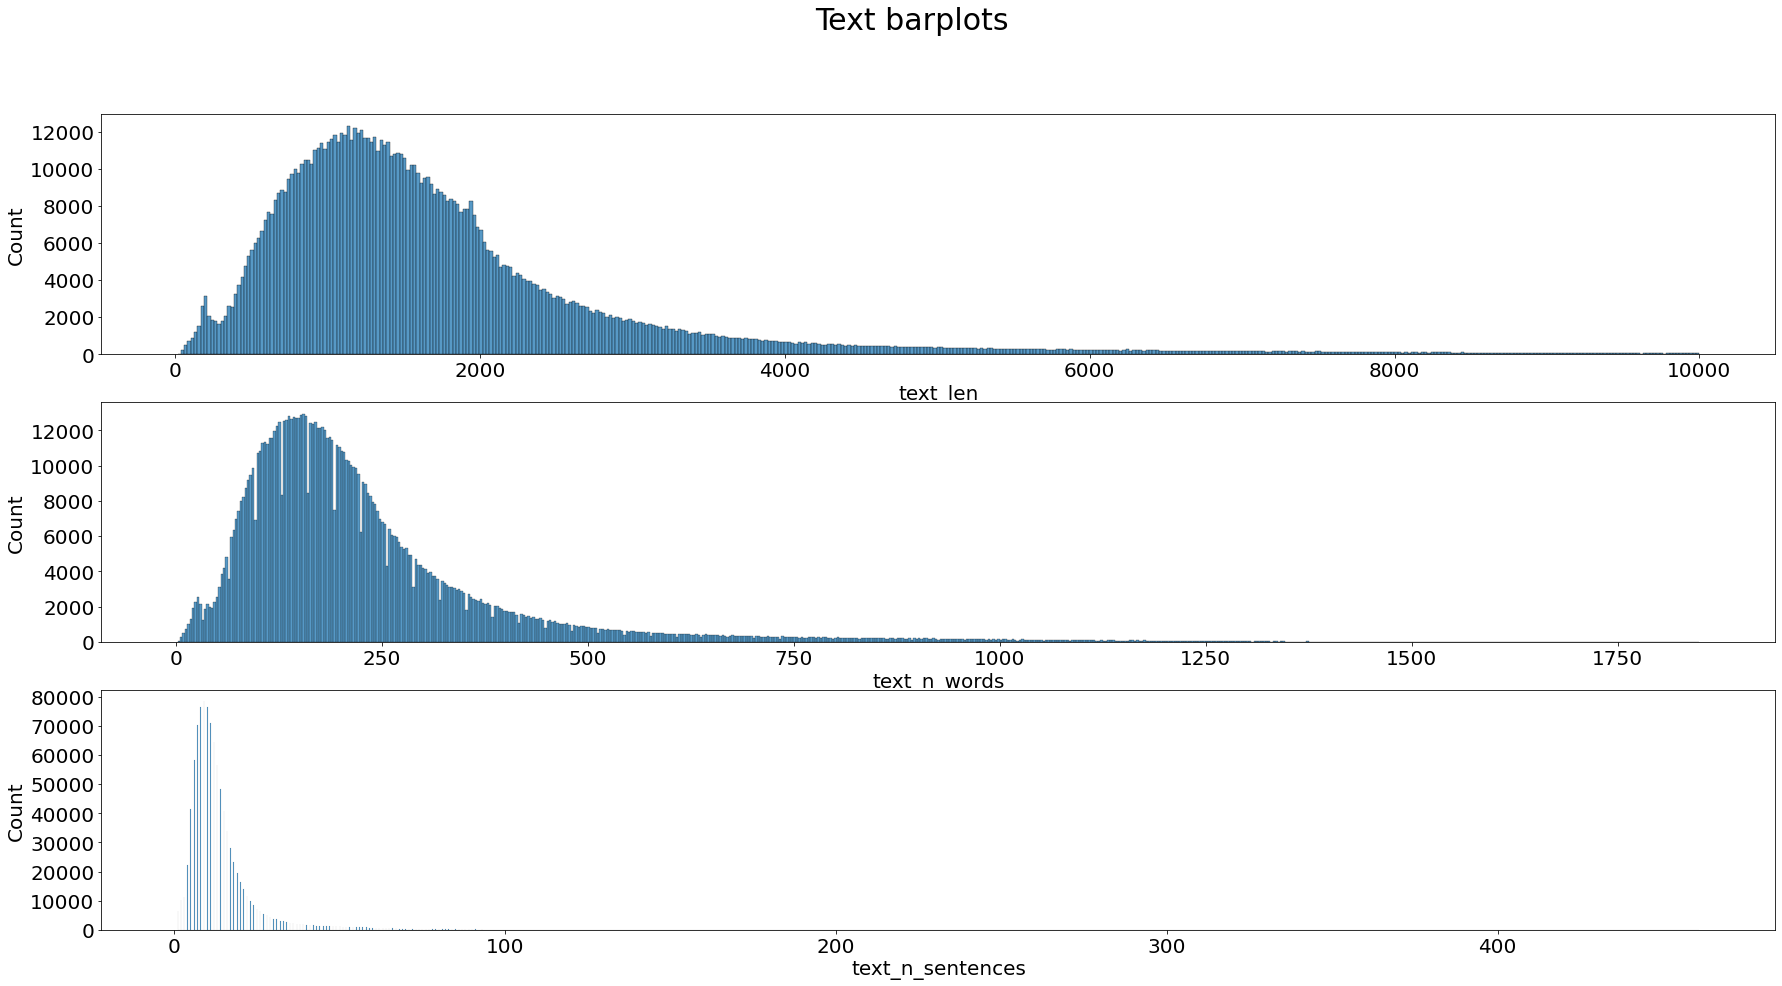

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(30, 15))
fig.suptitle('Text barplots', fontsize=30)

axes = [set_font_size(ax) for ax in axes]

sns.histplot(data.text_len, ax=axes[0])
sns.histplot(data.text_n_words, ax=axes[1])
sns.histplot(data.text_n_sentences, ax=axes[2])

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(30, 15))
fig.suptitle('Title barplots', fontsize=30)

axes = [set_font_size(ax) for ax in axes]

sns.histplot(data.title_len, ax=axes[0])
sns.histplot(data.title_n_words, ax=axes[1])
sns.histplot(data.title_n_sentences, ax=axes[2])

<AxesSubplot:xlabel='title_n_sentences', ylabel='Count'>

In [22]:
# data.to_excel('data/prepared_data.xlsx', index=False)

## Разделим данные на части:

In [23]:
train_size = 0.9
val_size = 0.05
test_size = 0.05

train_data, val_data, test_data = np.split(
    data.sample(frac=1, random_state=SEED),
    [int(train_size*len(data)), int((train_size + val_size)*len(data))]
)

In [24]:
def save_data_in_file(data, path_to_file):
    with open(path_to_file, 'w') as f:
        data.text.apply(lambda x: f.write(x + '\n'))
        data.title.apply(lambda x: f.write('@highlight ' + x + '\n'))

In [25]:
# save_data_in_file(test_data, './data/test_data.txt')

In [26]:
# save_data_in_file(validate_data, './data/val_data.txt')

In [27]:
# save_data_in_file(train_data, './data/train_data.txt')

## BertSum

Этот подход позволяет обучать модели как abstractive, так и extractive суммаризации, а так же гибридную модель.
В настоящее время показывает sota перфоманс на некоторых датасетах.

### Подготовим данные в нужном формате:

In [25]:
def prepare_bertsum_data(data):
    data_bertsum = []
    for text, title in data[['text', 'title']].values:
        item = {
            "src": [word_tokenize(sent) for sent in sent_tokenize(text)],
            "tgt": [word_tokenize(sent) for sent in sent_tokenize(title)]
        }
        data_bertsum.append(item)
    return data_bertsum

In [26]:
test_data_bertsum = prepare_bertsum_data(test_data)

In [27]:
val_data_bertsum = prepare_bertsum_data(val_data)

In [28]:
train_data_bertsum = prepare_bertsum_data(train_data)

In [29]:
min_src_ntokens_per_sent = 5
max_src_ntokens_per_sent = 100
max_src_nsents = 100

class BertData:
    def __init__(self, bert_model, lower, max_src_tokens, max_tgt_tokens):
        self.max_src_tokens = max_src_tokens
        self.max_tgt_tokens = max_tgt_tokens
        self.tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=lower)
        self.sep_token = '[SEP]'
        self.cls_token = '[CLS]'
        self.pad_token = '[PAD]'
        self.tgt_bos = '[unused1] '
        self.tgt_eos = ' [unused2]'
        self.tgt_sent_split = ' [unused3] '
        self.sep_vid = self.tokenizer.vocab[self.sep_token]
        self.cls_vid = self.tokenizer.vocab[self.cls_token]
        self.pad_vid = self.tokenizer.vocab[self.pad_token]

    def preprocess(self, src, tgt):
        src_txt = [' '.join(s) for s in src]
        text = ' {} {} '.format(self.sep_token, self.cls_token).join(src_txt)
        src_tokens = self.tokenizer.tokenize(text)[:self.max_src_tokens]
        src_tokens.insert(0, self.cls_token)
        src_tokens.append(self.sep_token)
        src_indices = self.tokenizer.convert_tokens_to_ids(src_tokens)

        _segs = [-1] + [i for i, t in enumerate(src_indices) if t == self.sep_vid]
        segs = [_segs[i] - _segs[i - 1] for i in range(1, len(_segs))]
        segments_ids = []
        for i, s in enumerate(segs):
            if i % 2 == 0:
                segments_ids += s * [0]
            else:
                segments_ids += s * [1]
        cls_ids = [i for i, t in enumerate(src_indices) if t == self.cls_vid]

        tgt_txt = ' <q> '.join([' '.join(sentence) for sentence in tgt])
        tgt_tokens = [' '.join(self.tokenizer.tokenize(' '.join(sentence))) for sentence in tgt]
        tgt_tokens_str = self.tgt_bos + self.tgt_sent_split.join(tgt_tokens) + self.tgt_eos
        tgt_tokens = tgt_tokens_str.split()[:self.max_tgt_tokens]
        tgt_indices = self.tokenizer.convert_tokens_to_ids(tgt_tokens)

        return src_indices, tgt_indices, segments_ids, cls_ids, src_txt, tgt_txt

In [58]:
import copy
from tqdm.notebook import tqdm

def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    sentences = [" ".join(s).lower() if lower else " ".join(s) for s in text][:max_sentences]
    gold_summary = [" ".join(s).lower() if lower else " ".join(s) for s in gold_summary]

    output = {
        "text": text,
        "summary": gold_summary
    }

    def indices_to_text(indices):
        return " ".join([sentences[index] for index in sorted(list(indices))])

    n_sentences = len(sentences)

    scores = []
    final_score = -1.0
    final_indices = set()
    final_scores = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in final_indices:
                continue
            indices = copy.copy(final_indices)
            indices.add(i)
            summary = indices_to_text(indices)
            for sm in gold_summary:
                try:
                    scores.append((calc_score(summary, sm), indices))
                except:
                    pass
        # If metrics didn't increase in outer loop, stop
        best_score, best_indices = max(scores)
        scores = []
        if best_score <= final_score:
            break
        final_scores.append(best_score)
        final_score, final_indices = best_score, best_indices

    final_scores = final_scores[:3]
    final_indices = list(final_indices)[:3]
    oracle_indices = [1 if i in final_indices else 0 for i in range(len(sentences))]
    output.update({
        "sentences": sentences,
        "oracle": oracle_indices
    })
    return output


def calc_single_score(pred_summary, gold_summary, rouge):
    score = rouge.get_scores(pred_summary, gold_summary, avg=True)
    return (score['rouge-2']['f'] + score['rouge-1']['f'] + score['rouge-l']['f']) / 3

In [61]:
def prepare_pytorch_data(bertsum_data, bert_path, save_path, lower, max_src_tokens, max_tgt_tokens, chunk_size):
    
    bert = BertData(bert_path, lower, max_src_tokens, max_tgt_tokens)
    chunk = []
    chunk_id = 0

    for item in tqdm(bertsum_data):
        src = item['src']
        tgt = item['tgt']
        
        rouge = Rouge()
        calc_score = lambda x, y: calc_single_score(x, y, rouge)
        oracle_record = build_oracle_summary_greedy(src, tgt, calc_score=calc_score, lower=False, max_sentences=100)
        
        sent_labels = oracle_record['oracle']
        
        (src_indices,
             tgt_indices,
                 segments_ids,
                     cls_ids,
                         src_txt,
                             tgt_txt) = bert.preprocess(src, tgt)

        b_data_dict = {
            "src": src_indices, "tgt": tgt_indices,
            "segs": segments_ids, 'clss': cls_ids,
            'src_txt': src_txt, "tgt_txt": tgt_txt,
            'src_sent_labels': sent_labels
        }
        chunk.append(b_data_dict)
        if len(chunk) == chunk_size:
            torch.save(chunk, save_path[:-7] + str(chunk_id) + save_path[-7:])
            chunk = []
            chunk_id += 1
            
    if chunk:
        torch.save(chunk, save_path[:-7] + str(chunk_id) + save_path[-7:])

In [62]:
prepare_pytorch_data(
    test_data_bertsum,
    '/home/kurochkin/DP_chatBot/experiments/rubert_cased_L-12_H-768_A-12_pt',
    '/home/kurochkin/DP_chatBot/experiments/data/test.bert.pt', 
    lower=False,
    max_src_tokens=512,
    max_tgt_tokens=128,
    chunk_size=2000
)

In [63]:
prepare_pytorch_data(
    val_data_bertsum,
    '/home/kurochkin/DP_chatBot/experiments/rubert_cased_L-12_H-768_A-12_pt',
    '/home/kurochkin/DP_chatBot/experiments/data/val.bert.pt', 
    lower=False,
    max_src_tokens=512,
    max_tgt_tokens=128,
    chunk_size=2000
)

In [64]:
prepare_pytorch_data(
    train_data_bertsum,
    '/home/kurochkin/DP_chatBot/experiments/rubert_cased_L-12_H-768_A-12_pt',
    '/home/kurochkin/DP_chatBot/experiments/data/train.bert.pt', 
    lower=False,
    max_src_tokens=512,
    max_tgt_tokens=128,
    chunk_size=2000
)

In [ ]:
%%script bash

PRESUM_PATH="/home/kurochkin/DP_chatBot/experiments/PreSumm/src"
BERT_DATA_PATH="/home/kurochkin/DP_chatBot/experiments/data/"
LOGS_PATH="/home/kurochkin/DP_chatBot/experiments/logs"
MODEL_PATH="/home/kurochkin/DP_chatBot/experiments/models"
export BERT_PATH="/home/kurochkin/DP_chatBot/experiments/rubert_cased_L-12_H-768_A-12_pt"

python "$PRESUM_PATH/train.py"  -task abs -mode train -bert_data_path "$BERT_DATA_PATH" \
  -dec_dropout 0.2 -model_path "$MODEL_PATH" -sep_optim true -lr_bert 1.0 -lr_dec 1.0 \
  -dec_layers 3 -save_checkpoint_steps 1000 -batch_size 2 -train_steps 50000 -report_every 50 \
  -accum_count 50 -use_bert_emb true -use_interval true -warmup_steps_bert 10000 \
  -warmup_steps_dec 5000 -max_pos 1024 -visible_gpus 1,3 -log_file "$LOGS_PATH/log.txt"

# Evaluation:

In [3]:
path_test_gold = '../results/validation_result.log.86000.gold'
path_test_predict = '../results/validation_result.log.86000.candidate'
path_test_raw_src = '../results/validation_result.log.86000.raw_src'

In [4]:
with open(path_test_gold) as f:
    tgt_gold = f.read().splitlines()

In [5]:
with open(path_test_predict) as f:
    tgt_candidates = f.read().splitlines()

In [6]:
with open(path_test_raw_src) as f:
    raw_src = f.read().splitlines()

In [7]:
def untokenize(text):
    step1 = text.replace("` ` ", '"').replace(" ' '", '"').replace("''", '"').replace('. . .',  '...').replace('<q>', '')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()

### Postprocessed and detokenized:

In [8]:
tgt_candidates = [untokenize(text) for text in tgt_candidates]

In [9]:
tgt_gold = [untokenize(text) for text in tgt_gold]

In [10]:
rouge = Rouge()
scores = rouge.get_scores(tgt_candidates, tgt_gold, avg=True)

In [11]:
print("rouge-1-f\trouge-2-f\t\trouge-l-f")
print("\t".join([str(scores["rouge-1"]["f"])[:10],
                 str(scores["rouge-2"]["f"])[:10],
                 str(scores["rouge-l"]["f"])[:10]]))
print("R-mean: ", (scores["rouge-1"]["f"] + scores["rouge-2"]["f"] + scores["rouge-l"]["f"]) / 3)

rouge-1-f	rouge-2-f		rouge-l-f
0.35970157	0.19266374	0.34772998
R-mean:  0.30003176778051266


In [12]:
scores

{'rouge-1': {'f': 0.35970157067314096,
  'p': 0.3093798464292354,
  'r': 0.44634133519842256},
 'rouge-2': {'f': 0.19266374367288933,
  'p': 0.1631457352432526,
  'r': 0.2462850851953882},
 'rouge-l': {'f': 0.3477299889955076,
  'p': 0.3050675882449137,
  'r': 0.4176931578833703}}

### Postprocessed and tokenized:

In [13]:
tgt_candidates = [" ".join(word_tokenize(text)) for text in tgt_candidates]

In [14]:
tgt_gold = [" ".join(word_tokenize(text)) for text in tgt_gold]

In [15]:
rouge = Rouge()
scores = rouge.get_scores(tgt_candidates, tgt_gold, avg=True)

In [16]:
print("rouge-1-f\trouge-2-f\t\trouge-l-f")
print("\t".join([str(scores["rouge-1"]["f"])[:10],
                 str(scores["rouge-2"]["f"])[:10],
                 str(scores["rouge-l"]["f"])[:10]]))
print("R-mean: ", (scores["rouge-1"]["f"] + scores["rouge-2"]["f"] + scores["rouge-l"]["f"]) / 3)

rouge-1-f	rouge-2-f		rouge-l-f
0.39504620	0.21743401	0.38096792
R-mean:  0.3311493803921466


In [17]:
scores

{'rouge-1': {'f': 0.39504620007672486,
  'p': 0.33246919807169,
  'r': 0.5027417682045037},
 'rouge-2': {'f': 0.2174340170684353,
  'p': 0.18076623702851163,
  'r': 0.2842346883120514},
 'rouge-l': {'f': 0.38096792403127955,
  'p': 0.32567630961113714,
  'r': 0.4719673329712448}}

### Посмотрим на финальные предсказания:

In [18]:
tgt_candidates = [untokenize(text) for text in tgt_candidates]
tgt_gold = [untokenize(text) for text in tgt_gold]
raw_src = [text.replace('[CLS] ', '').replace('[SEP] ', '').replace(' [PAD]', '').replace(' ##', '').strip() for text in raw_src]

In [19]:
final_report = pd.DataFrame({'text': raw_src, 'title': tgt_gold, 'predict': tgt_candidates})

In [20]:
for text, gold, cand in final_report.sample(20).values:
    print("TEXT: ", text, '\n')
    print("GOLD: ", gold, '\n')
    print("CAND: ", cand, "\n", "=============================================",'\n\n\n')

TEXT:  киев , 22 янв - риа новости , марина шмаюн . законы , способствующие активному проведению реформ на украине , будут приняты в первом полугодии 2011 года , заявил в пятницу вечером в эфире украинского телеканала ` ` интер ' ' вице - премьер - министр социальной политики сергей тигипко . ` ` я думаю , что пенсионная ( реформа ) в марте будет принята , это будет первый этап . я бы рекомендовал ввести второй уровень накопительной системы , чтобы он начал работать с 2013 года ' ' , сказал тигипко . он высказал мнение , что в мае будут приняты поправки , которые значительно улучшат налоговый кодекс . ` ` таможенный кодекс тоже можем до мая принять , оговорить ' ' , - заявил тигипко . украинские коммерсанты вышли на площадь независимости в киеве после того , как 18 ноября прошлого года парламент принял налоговый кодекс , который , по мнению предпринимателей , уничтожит малый и средний бизнес . после недельной акции протеста президент виктор янукович ветировал документ , согласившись с 